# Programa 9
### Integrantes:
- Silva Velázquez Elsy Camila
- Longines Tapia Hugo Didier
- Andrés Urbano Guillermo Gerardo


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [ ]:
#df = pd.read_csv('CPIAUCSL.csv')
df = pd.read_csv('CPIAUCSL.csv', index_col=['DATE'], parse_dates=['DATE'])
df.head()

,CPIAUCSL
DATE,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


## Media movil

In [ ]:
def plot_MA(series, window, plot_intervals=False, scale=1.96,
            plot_anormalies=False):
    """
    plot_intervals - para graficar el error
    plot_anormalies - nos ayuda a hacer zoom, ver la anomlias
    """
    rolling_mean = series.rolling(window=window).mean() # pandas
    plt.figure(figsize=(15,5))
    plt.title('Media móvil\n tamaño de ventana={}'.format(window))
    plt.plot(rolling_mean, 'g', label='Tendencia')
    #*********
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        dev = np.std(series[window:]-rolling_mean[window:])
        upper_ =rolling_mean + (mae + scale*dev)
        lower_ =rolling_mean - (mae + scale*dev)
        plt.plot(upper_, 'r--', label='Límites superior/inferior')
        plt.plot(lower_, 'r--')
    if plot_anormalies:
        anomalies = pd.DataFrame(index=series.index, columns=series.columns)
        anomalies[series < lower_] = series[series < lower_]
        anomalies[series > upper_] = series[series > upper_]
        plt.plot(anomalies, 'ro', markersize=10)

    plt.plot(series[window:], label='Valores reales')
    plt.legend(loc='upper left')
    plt.grid(True)      

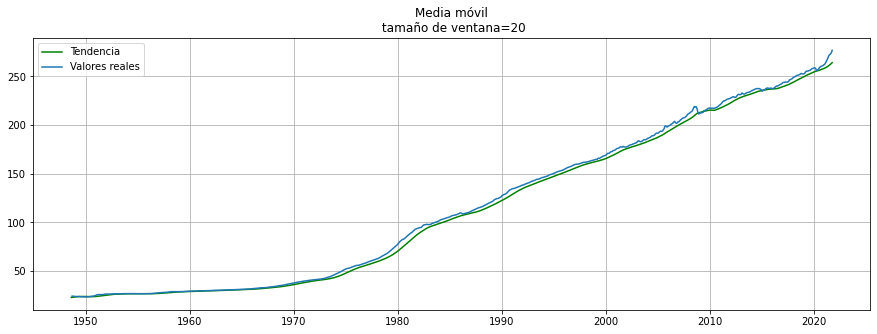

In [ ]:
plot_MA(df, 20)

Vemos los datos siguen una tendencia, no hay caidas y subidas.

## Exponencial

In [ ]:
# Suavidado exponencial
# Se encuentra en 
# statsmodels.tsa.api.SimpleExpSmoothing

def exp_smooth(series, alpha):
    res = [series[0]]
    for n in range(1, len(series)):
        res.append(alpha * series[n] + (1-alpha) * res[n-1])
    return res

In [ ]:
def plot_exp_smooth(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exp_smooth(series, alpha),
                     label='Alpha {}'.format(alpha))
        plt.plot(series.values, 'c', label='Real')
        plt.legend(loc='best')
        plt.title('Suavizado exponencial')
        plt.grid(True)
        plt.show()

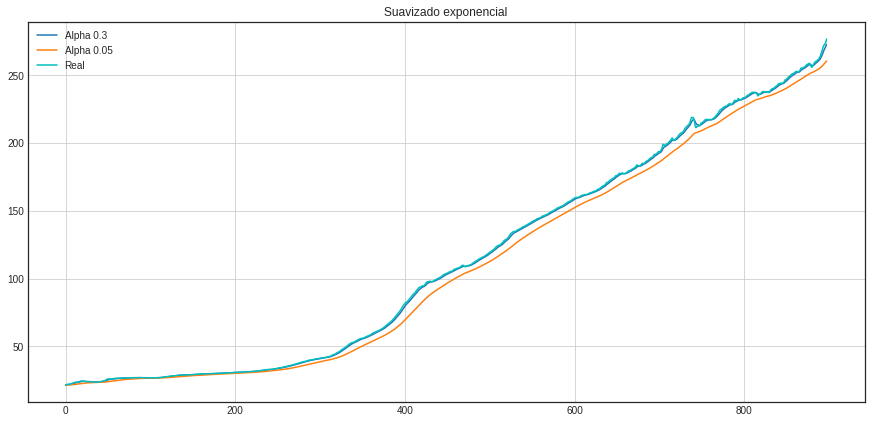

In [ ]:
plot_exp_smooth(df.CPIAUCSL, [0.3, 0.05])

## Holt-Winters

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def plot_HW_2(series, n=20):
    hw = ExponentialSmoothing((series), seasonal_periods=12).fit()
    # forescat
    train, test = series[:-n], series[len(series)-n:]
    hw_p = hw.predict(start=test.index[0], end=test.index[-1])
    plt.figure(figsize=(15, 7))    
    plt.plot(train.index, train, label='Entrenamiento')
    plt.plot(test.index, test, label='Prueba')
    plt.plot(hw_p.index, hw_p, label='Holt-Winters')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


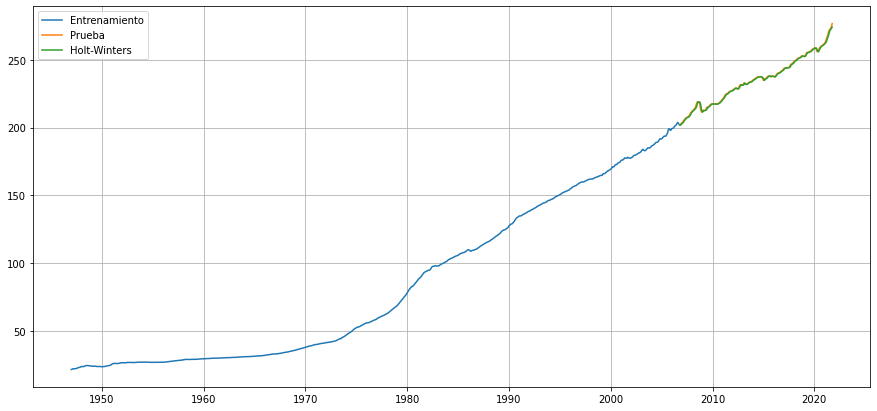

In [ ]:
plot_HW_2(df.CPIAUCSL, 180)


## Regresión lineal

In [ ]:
# Analisis de series de tiempo basados en regresión lineal
data = pd.DataFrame(df.CPIAUCSL)
data.columns=['y']
data.tail(3)

,y
DATE,
2021-08-01,273.012
2021-09-01,274.138
2021-10-01,276.724


In [ ]:
# Agregamos los lags (retrasos) de la variables objetivo de 6 a 24
for i in range(6, 25):
    data['lag_{}'.format(i)] = data.y.shift(i)

data.tail(3)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
DATE,,,,,,,,,,,,,,,,,,,,
2021-08-01,273.012,263.161,262.231,261.560,260.927,260.462,260.149,259.511,258.604,257.282,255.942,256.192,257.989,258.824,258.687,258.203,257.989,257.387,256.532,256.118
2021-09-01,274.138,264.793,263.161,262.231,261.560,260.927,260.462,260.149,259.511,258.604,257.282,255.942,256.192,257.989,258.824,258.687,258.203,257.989,257.387,256.532
2021-10-01,276.724,266.832,264.793,263.161,262.231,261.560,260.927,260.462,260.149,259.511,258.604,257.282,255.942,256.192,257.989,258.824,258.687,258.203,257.989,257.387


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# validación cruzada con 5 folds {doblete}
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    return X_train, y_train, X_test, y_test

In [ ]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X.head(3)

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
DATE,,,,,,,,,,,,,,,,,,,
1949-01-01,24.40,24.15,24.01,23.82,23.50,23.67,23.68,23.41,23.06,22.91,22.84,22.40,22.23,22.08,21.95,22.00,22.00,21.62,21.48
1949-02-01,24.43,24.40,24.15,24.01,23.82,23.50,23.67,23.68,23.41,23.06,22.91,22.84,22.40,22.23,22.08,21.95,22.00,22.00,21.62
1949-03-01,24.36,24.43,24.40,24.15,24.01,23.82,23.50,23.67,23.68,23.41,23.06,22.91,22.84,22.40,22.23,22.08,21.95,22.00,22.00


In [ ]:
X_train, y_train, X_test, y_test = timeseries_train_test_split(X, y, 0.3)

In [ ]:
# Modelo de regresion
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Metricas
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_predict):
    return np.mean(np.abs(y_true - y_predict  / y_true)) * 100

In [ ]:
def plot_model_result(model, X_train, y_train, X_test, y_test,
                      plot_intervals=False, scale=1.96):
    pred = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(pred, 'g', label='Predicción', linewidth=2.0)
    plt.plot(y_test.values, 'b', label='Reales', linewidth=2.0)    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv,
                             scoring='neg_mean_absolute_error')
        mae = cv.mean() * -1        
        dev = cv.std()
        low = pred - (mae + scale*dev)
        upp = pred + (mae + scale*dev)
        plt.plot(low, 'r--', label='limites superior/inferior', alpha=0.5)
        plt.plot(upp, 'r--', alpha=0.5)
    
    # Agregar anomalias (opcional)
    error = mean_absolute_percentage_error(pred, y_test)
    plt.title('Error absoluto promedio = {0:.2f}%'.format(error))
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

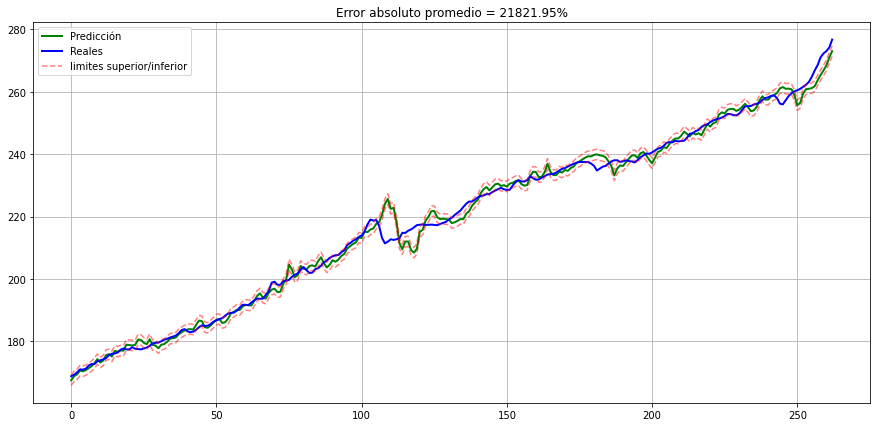

In [ ]:
plot_model_result(lr, X_train, y_train, X_test, y_test, plot_intervals=True)

**Conclusiones**

Podemos darnos cuenta que en la regresión lineal aparecen picos y bajadas que 
no tienen en los otros métodos.

Vemos que la media movil esta mas cerca de los valores reales a comparacion con suvizado exponencial. Podemos concluir que en este caso, es más preciso la media movil.

Podemos ver que en la gráfica de Holt-Winters se acerca muy bien a los datos de prueba, que al final son datos reales de nuestro conjunto de datos.

Concluimos que la gráfica que peor se aproxima a nuestro datos la regresión lineal debido a que generar picos y bajas a lo largo del tiempo que no perteneces a la gráfica original. Y la mejor gráfica que se aproxima es la Holt-Winters.